# Regresión Lineal

## Formulación matemática


La regresión lineal es un modelo que mapea una o más variables continuas hacia una variable también continua. El modelo se define matemáticamente como:

$$
f_\theta(\vec x_i) = \theta_0 + \sum_{j=1}^M \theta_j x_{ij} 
$$

Asumiendo que tenemos $N$ ejemplos para entrenar, podemos plantear el sistema de ecuaciones matricialmente como

$$
Y = X \theta
$$

donde $Y= \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\y_N\end{pmatrix} \in \mathbb{R}^N$, $X = \begin{pmatrix} 1 & x_{11} & x_{12}& \ldots& x_{1M} \\ \vdots & \vdots & \vdots& \ddots& \vdots \\ 1 & x_{N1} & x_{N2}& \ldots& x_{NM} \\ \end{pmatrix} \in \mathbb{R}^{N\times M}$ y $\theta \in \mathbb{R}^M$

Para medir la calidad del modelo usamos la suma de errores cuadrados, la cual en notación matricial es

$$
L(\theta) = \frac{1}{2} (Y - X\theta)^T (Y - X\theta)
$$

Si derivamos e igualamos a cero la expresión anterior se obtiene

$$
\nabla_\theta L(\theta) = -X^T(Y-X\theta) = 0,
$$

despejando la solución es

$$
\hat \theta = (X^T X)^{-1} X^T Y
$$

siempre $X^T X$ no sea singular (no invertible).

:::{note}

El resultado anterior se conoce como la solución de mínimos cuadrados ordinarios (*ordinary least squares* o OLS).

:::

## Implementación en Scikit-Learn

La solución de mínimos cuadrados está implementada en la librería scikit-learn como [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Sus principales argumentos son:

- `fit_intercept=True`: Ajustar o no el parámetro $\theta_0$
- `n_jobs`: Número de nucleos de CPU para ajustar

Sus principales métodos son:

- `fit(X, y)`: Ajuste los parámetros según la solución de mínimos cuadrados. 
- `predict(X)`: Retorna la predicción para un conjunto de datos
- `score(X, y)`: Retorna el [coeficiente de determinación](https://es.wikipedia.org/wiki/Coeficiente_de_determinaci%C3%B3n)

:::{note}

- `X` es un *ndarray* de dos dimensiones (matriz)
- `y` es un *ndarray* de una dimensión (vector)

:::

Los principales atributos son:

- `intercept_`: Corresponde a $\theta_0$
- `coef_`: Es un arreglo con $\theta_j$ para $j>0$


**Ejemplo**

Consideremos los siguientes datos 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1234)
x = np.random.randn(30)
y = -0.5*x**4 + 2*x**3 -3 + np.random.randn(len(x))

Para ajustar el modelo a este dataset utilizamos

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
print(f"Coeficiente de determinación: {model.score(x.reshape(-1, 1), y):0.4f}")

Coeficiente de determinación: 0.6603


Luego para realizar una predicción sobre nuevos datos:

In [3]:
x_test = np.linspace(x.min(), x.max(), 200)
y_test = model.predict(x_test.reshape(-1, 1))

A continuación se grafican los datos y la predicción del modelo (izquierda) junto a los residuos del modelo (derecha)

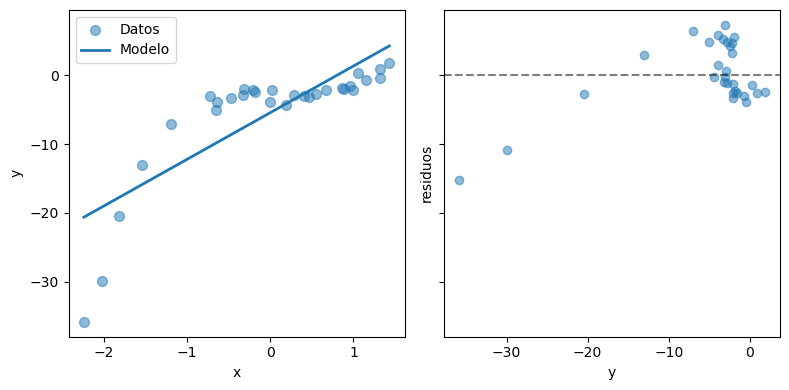

In [4]:
def plot_prediction(x, y, x_test, y_test, model):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
    ax[0].scatter(x, y, s=50, label='Datos', alpha=0.5)
    ax[0].plot(x_test, y_test, label='Modelo', lw=2, )
    ax[0].legend()
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[1].scatter(y, y - model.predict(x.reshape(-1, 1)), alpha=0.5)
    ax[1].axhline(0, c='k', ls='--', alpha=0.5)
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('residuos')
    
plot_prediction(x, y, x_test, y_test, model)   

El gráfico de residuos es un gráfico de dispersión (*scatter plot*) de $y$ versus $y - f_\theta(x)$. Es bastante usado para analizar los errores de un modelo de regresión. 

:::{important}

Un modelo adecuado debería tener sus residuos concentrados en torno a cero y libres de correlación.

:::

En este caso, los residuos no cumplen ninguna de las condiciones anteriores. 

También podemos medir la calidad del modelo utilizando el error medio cuadrático, que es la suma de errores cuadrados dividido por la cantidad de datos:

In [5]:
from sklearn.metrics import mean_squared_error
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")

MSE: 24.1281


Mientras más cercano a cero sea el MSE, mejor es el ajuste del modelo.

## Regresión polinomial con Scikit-Learn

Podemos generalizar el regresor lineal aplicando transformaciones a los datos. Por ejemplo una regresión polinomial de grado $M$ sería

$$
f_\theta(x_i) = \theta_0 + \sum_{j=1}^M \theta_j x_{i}^j, 
$$

y su solución sería

$$
\hat \theta = (\Phi^T \Phi)^{-1} \Phi^T Y,
$$

donde 

$$
\Phi = \begin{pmatrix} 1 & x_1 & x_1^2& \ldots& x_1^M \\ \vdots & \vdots & \vdots& \ddots& \vdots \\ 1 & x_N & x_N^2& \ldots& x_N^M \\ \end{pmatrix}
$$

:::{important}

El grado del polinomio es un **hiperparámetro** del modelo. Los hiperparámetros son valores que el usuario fija antes de ajustar.

:::

En scikit learn podemos utilizar [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) para realizar esta transformación. Por ejemplo un polinomio de grado dos se obtiene con:

In [6]:
from sklearn.preprocessing import PolynomialFeatures

featurizer = PolynomialFeatures(degree=2)

display(featurizer.fit_transform(np.array([[1.], [2.], [3.]])))

array([[1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])

Podemos crear un regresor polinomial definiendo un [`Pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline).

:::{note}

En scikit-learn, un pipeline es una cadena de objetos de scikit-learn. Si llamamos al método `fit` del pipeline, se llamará al método `fit` de cada elemento de la cadena en orden.

:::

El siguiente pipeline combina `PolynomialFeatures` y `LinearRegression`:

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=3), 
                      LinearRegression(fit_intercept=False))
model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [8]:
model.fit(x.reshape(-1, 1), y)
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")
y_test = model.predict(x_test.reshape(-1, 1))

MSE: 0.7179


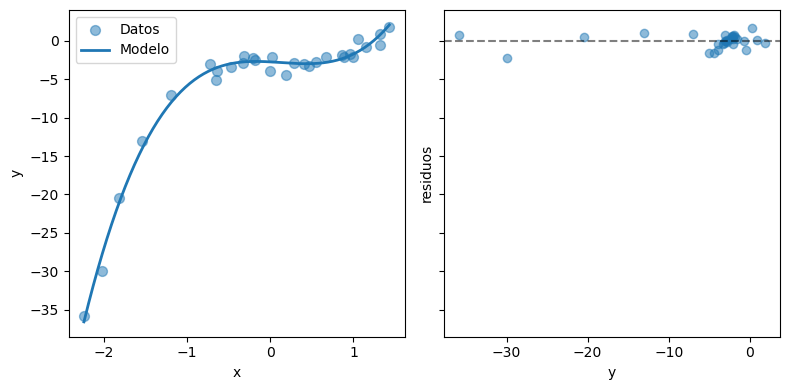

In [9]:
plot_prediction(x, y, x_test, y_test, model)

El MSE se ha reducido en comparación al caso anterior. Visualmente el modelo sigue mejor a los datos. Además los residuos están más concentrados en cero y tienen menos correlación.

> ¿Qué ocurre su usamos un polinomio de grado mayor?

Intentemos ajustar nuevamente pero con un polinomio de grado 15.

In [10]:
model = make_pipeline(PolynomialFeatures(degree=15), 
                      LinearRegression())

model.fit(x.reshape(-1, 1), y)
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")
y_test = model.predict(x_test.reshape(-1, 1))

MSE: 0.2526


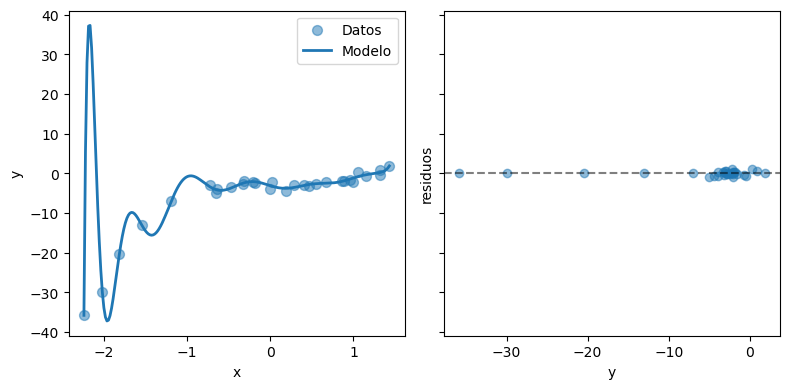

In [11]:
plot_prediction(x, y, x_test, y_test, model)

El MSE es aun más bajo, el modelo sigue perfectamente los datos y los residuos son casi cero. 

> ¿Creé usted que este es un buen resultado?

:::{warning}

Lo que estamos observando es un ejemplo de sobreajuste. Estudiaremos esto en detalle en la próxima lección.

:::